### Is the subnetwork doing the same thing as the main RNN?

In [81]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_augmented import A2CRNNAugmented
from agents.networks.gru_rnn import GRU_RNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, logical_and
from numpy.linalg import norm
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\david.bell\work\favorably_connected\code\notebooks


In [22]:
# Load weights from given `load_path`
def load_network(load_path):
    subnetwork = GRU_RNN(
        input_size=SUB_INPUT_SIZE,
        hidden_size=SUB_HIDDEN_SIZE,
        output_size=SUB_OUTPUT_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    network = A2CRNNAugmented(
        subnetwork=subnetwork,
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data, flattened_data

In [3]:
weight_paths = [
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00050.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00100.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00150.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00200.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00250.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00300.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00500.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01000.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01500.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/02000.pth',
]

hidden_and_behavior_paths = [
    # 'test_augment_pretrain_2025-03-13_22_23_41_484413_var_noise_0_activity_weight_0_sn_00050',
    # 'test_augment_pretrain_2025-03-13_22_29_02_566759_var_noise_0_activity_weight_0_sn_00100',
    # 'test_augment_pretrain_2025-03-13_22_34_23_777244_var_noise_0_activity_weight_0_sn_00150',
    # 'test_augment_pretrain_2025-03-13_22_39_01_813740_var_noise_0_activity_weight_0_sn_00200',
    # 'test_augment_pretrain_2025-03-13_22_50_57_641228_var_noise_0_activity_weight_0_sn_00250',
    # 'test_augment_pretrain_2025-03-13_22_55_59_298068_var_noise_0_activity_weight_0_sn_00300',
    # 'test_augment_pretrain_2025-03-21_13_56_11_433378_var_noise_0_activity_weight_0_sn_00500',
    # 'test_augment_pretrain_2025-03-21_14_00_24_563438_var_noise_0_activity_weight_0_sn_01000',
    # 'test_augment_pretrain_2025-03-21_14_16_30_328359_var_noise_0_activity_weight_0_sn_01500',
    'test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000',
]

In [23]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    hidden_activities, pc_activities, all_session_data, flattened_hidden = load_hidden_and_behavior(hidden_and_behavior_path)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']


In [5]:
print(hidden_activities.shape)

(160, 120, 20000)


### Fit CCA with increasing number of components
Attempt to predict subnetwork activity from main network. Also extract canonical correlations.

In [111]:
kf = KFold(n_splits=5)
cca_scores = []
cca_dims = [1, 3, 5, 10, 20, 32]
for i in cca_dims:
    pred_scores_for_n_comp = []
    canonical_corrs_for_n_comp = []
    for train, test in kf.split(flattened_data):
        cca = CCA(n_components=i, max_iter=5000)
        X_train = flattened_hidden.T[train, :HIDDEN_SIZE]
        Y_train = flattened_hidden.T[train, HIDDEN_SIZE:]
    
        X_test = flattened_hidden.T[test, :HIDDEN_SIZE]
        Y_test = flattened_hidden.T[test, HIDDEN_SIZE:]
        
        cca.fit(X_train, Y_train)

        X_c, Y_c = cca.transform(X_test, Y_test) 
    
        # Y_train_shuffled = copy(Y_train)
        # ordering = np.arange(len(train))
        # np.random.shuffle(ordering)
        # Y_train_shuffled = Y_train_shuffled[ordering, :]
        pred_score = cca.score(X_test, Y_test)
        pred_scores_for_n_comp.append(pred_score)

        canonical_corrs = [np.corrcoef(X_c[:, j], Y_c[:, j])[0, 1] for j in range(i)]
        canonical_corrs_for_n_comp.append(canonical_corrs)
        
    cca_scores.append(np.mean(pred_scores_for_n_comp))

### Plot prediction accuracy of CCA

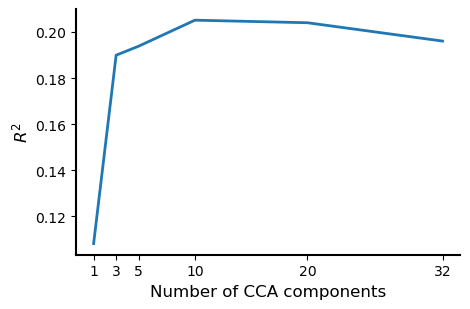

In [112]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

# Plot the CCA scores
axs.plot(cca_dims, cca_scores, linewidth=2)

# Axis labels
axs.set_xlabel("Number of CCA components", fontsize=12)
axs.set_ylabel(r"$R^2$", fontsize=12)

# Thicker axis lines
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)

# Remove top and right borders
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xticks(cca_dims)

# Larger tick font sizes
axs.tick_params(axis='both', which='major', labelsize=10)

# Optional: tighter layout
plt.tight_layout()

### Plot canonical correlations

32
32
32
32
32


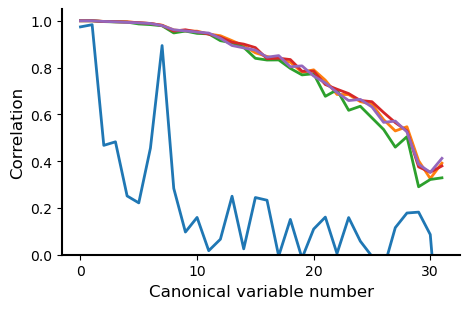

In [113]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

# Plot the CCA scores
for cc in canonical_corrs_for_n_comp:
    print(len(cc))
    axs.plot(np.arange(cca_dims[-1]), cc, linewidth=2)

axs.set_ylim(0, 1.05)
# Axis labels
axs.set_xlabel("Canonical variable number", fontsize=12)
axs.set_ylabel("Correlation", fontsize=12)

# Thicker axis lines
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)

# Remove top and right borders
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xticks([0, 10, 20, 30])

# Larger tick font sizes
axs.tick_params(axis='both', which='major', labelsize=10)

# Optional: tighter layout
plt.tight_layout()

### Predicting PCs of subnetwork from main RNN activity

In [85]:
main_hidden = hidden_activities[:HIDDEN_SIZE, ...]
subnetwork_hidden = hidden_activities[HIDDEN_SIZE:, ...]

flattened_main = main_hidden.reshape(main_hidden.shape[0], main_hidden.shape[1] * main_hidden.shape[2], order='C')
flattened_ha = subnetwork_hidden.reshape(subnetwork_hidden.shape[0], subnetwork_hidden.shape[1] * subnetwork_hidden.shape[2], order='C')

pca = PCA()
pc_activities_sub = pca.fit_transform(flattened_ha.T)
# pc_activities_sub = pc_activities_sub.T.reshape(subnetwork_hidden.shape, order='C')
flattened_main = flattened_main.T
print(pc_activities_sub.shape)

(2400000, 32)


In [99]:
dims = np.arange(0, 6)
splits = 5
kf = KFold(n_splits=splits)
all_r2 = np.empty((len(dims), splits))
for i, d_i in enumerate(dims):
    for s_i, (train, test) in enumerate(kf.split(flattened_main, pc_activities_sub)):
        print(flattened_main[train, np.array(d_i)].shape)
        reg = LinearRegression().fit(flattened_main[train, :], pc_activities_sub[train, np.array(d_i)])
        score = reg.score(flattened_main[test, :], pc_activities_sub[test, np.array(d_i)])
        all_r2[i, s_i] = score
        

(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)
(1920000,)


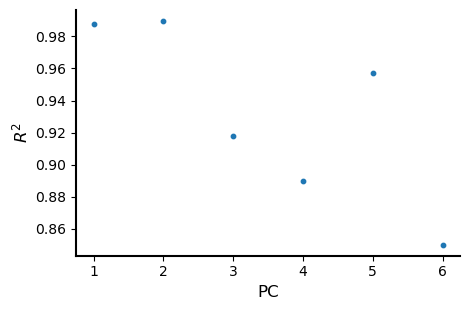

In [104]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

# Plot the CCA scores
axs.scatter(dims + 1, all_r2.mean(axis=1), s=10)

# Axis labels
axs.set_xlabel("PC", fontsize=12)
axs.set_ylabel(r"$R^2$", fontsize=12)

# Thicker axis lines
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)

# Remove top and right borders
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xticks(dims + 1)

# Larger tick font sizes
axs.tick_params(axis='both', which='major', labelsize=10)

# Optional: tighter layout
plt.tight_layout()